In [16]:
import numpy as np
import pandas as pd
import itertools
#from tqdm import tqdm
import matplotlib.pyplot as plt
#from pandas_datareader import data as web
plt.style.use("default")
import re
import requests
from bs4 import BeautifulSoup
# For reproducibility
np.random.seed(42)


In [17]:
# ------------------------------
# Universe from daily screener output (etf_screened_today.csv)
# ------------------------------
from pathlib import Path
repo_root = Path.cwd().parent

config_dir = repo_root / "data"
config_dir.mkdir(parents=True, exist_ok=True)

_screen_path = config_dir / "etf_screened_today.csv"

screen_df = pd.read_csv(_screen_path)

if "include_for_algo" not in screen_df.columns:
    raise ValueError(f"Screener CSV missing include_for_algo column: {_screen_path}")

screen_pass = screen_df[screen_df["include_for_algo"] == True].copy()

# Normalize tickers
for col in ["ETF", "Underlying"]:
    if col in screen_pass.columns:
        screen_pass[col] = (
            screen_pass[col].astype(str).str.strip().str.replace(".", "-", regex=False).str.upper()
        )

if "LevType" not in screen_pass.columns:
    raise ValueError(f"Screener CSV missing LevType column: {_screen_path}")
if "Underlying" not in screen_pass.columns or "ETF" not in screen_pass.columns:
    raise ValueError(f"Screener CSV must contain ETF + Underlying columns: {_screen_path}")

lt = screen_pass["LevType"].astype(str).str.upper()

cc_mask = lt.str.contains("CC") | lt.str.contains("COVER") | lt.str.contains("YM") | lt.str.contains("YIELD")
lev2_mask = (lt.str.contains("2") | lt.str.contains("2X") | lt.str.contains("LEV2") | lt.str.contains("DX")) & ~lt.str.contains("3")

# Build pair-definition dataframes expected by the rest of the notebook
ym_df = screen_pass.loc[cc_mask, ["ETF", "Underlying"]].copy()
ym_df["LevType"] = "CC"

dx_df = screen_pass.loc[lev2_mask, ["ETF", "Underlying"]].copy()
dx_df["LevType"] = "2x"

# Keep cc_df for backward compatibility with existing concat logic (can be empty)
cc_df = pd.DataFrame(columns=["ETF", "Underlying", "LevType"])

# Convenience lists (if later cells expect them)
covered_call_pairs_expanded = list(zip(ym_df["ETF"], ym_df["Underlying"]))
leverage_pairs = list(zip(dx_df["ETF"], dx_df["Underlying"]))

print(f"Screener path: {_screen_path}")
print(f"Included pairs: CC={len(ym_df)}, 2x={len(dx_df)}")
print("Sample CC pairs:", covered_call_pairs_expanded[:10])
print("Sample 2x pairs:", leverage_pairs[:10])


Screener path: c:\Users\werdn\Documents\Investing\ls-algo\data\etf_screened_today.csv
Included pairs: CC=39, 2x=71
Sample CC pairs: [('QYLD', 'QQQ'), ('QYLG', 'QQQ'), ('QQQX', 'QQQ'), ('JEPQ', 'QQQ'), ('XYLD', 'SPY'), ('XYLG', 'SPY'), ('JEPI', 'SPY'), ('SPYI', 'SPY'), ('ABNY', 'ABNB'), ('AMZY', 'AMZN')]
Sample 2x pairs: [('AAPU', 'AAPL'), ('AMUU', 'AMD'), ('AMZU', 'AMZN'), ('AVL', 'AVGO'), ('BITX', 'IBIT'), ('BOEU', 'BA'), ('CSCL', 'CSCO'), ('ELIL', 'LLY'), ('ETHU', 'ETHA'), ('LMTL', 'LMT')]


In [18]:
all_df = pd.concat([dx_df, cc_df, ym_df], ignore_index=True)
# make sure to exclude jp morgan
all_df = all_df.dropna(subset=["Underlying"])
all_df = all_df[all_df["Underlying"].astype(str).str.strip() != ""]

# Drop duplicate ETFs or duplicate rows if needed
all_df = all_df.drop_duplicates(subset=["ETF"]).reset_index(drop=True)
# Replace dots with dashes for Yahoo Finance compatibility
all_df["ETF"] = all_df["ETF"].str.replace(".", "-", regex=False)
all_df["Underlying"] = all_df["Underlying"].str.replace(".", "-", regex=False)

# Now create clean ticker lists
all_tickers = all_df["ETF"].tolist()

In [19]:
import ftplib

ftp = ftplib.FTP("ftp2.interactivebrokers.com")
ftp.login(user="shortstock", passwd="")  # password is blank / anonymous

files = ftp.nlst()
print(files)

ftp.quit()


['australia.txt', 'australia.txt.md5', 'austria.txt', 'austria.txt.md5', 'belgium.txt', 'belgium.txt.md5', 'british.txt', 'british.txt.md5', 'canada.txt', 'canada.txt.md5', 'dutch.txt', 'dutch.txt.md5', 'france.txt', 'france.txt.md5', 'germany.txt', 'germany.txt.md5', 'hongkong.txt', 'hongkong.txt.md5', 'india.txt', 'india.txt.md5', 'italy.txt', 'italy.txt.md5', 'japan.txt', 'japan.txt.md5', 'mexico.txt', 'mexico.txt.md5', 'singapore.txt', 'singapore.txt.md5', 'spain.txt', 'spain.txt.md5', 'stockmargin_final_dtls.IB-AU.dat', 'stockmargin_final_dtls.IB-AU.dat.md5', 'stockmargin_final_dtls.IB-CAN.dat', 'stockmargin_final_dtls.IB-CAN.dat.md5', 'stockmargin_final_dtls.IB-HK.dat', 'stockmargin_final_dtls.IB-HK.dat.md5', 'stockmargin_final_dtls.IB-IN.dat', 'stockmargin_final_dtls.IB-IN.dat.md5', 'stockmargin_final_dtls.IB-JP.dat', 'stockmargin_final_dtls.IB-JP.dat.md5', 'stockmargin_final_dtls.IB-SG.dat', 'stockmargin_final_dtls.IB-SG.dat.md5', 'stockmargin_final_dtls.IB-UKL.dat', 'stockmarg

'221 Goodbye.'

In [20]:
import ftplib
import io

def fetch_ibkr_shortstock_file(filename="usa.txt") -> pd.DataFrame:
    ftp = ftplib.FTP("ftp2.interactivebrokers.com")
    ftp.login(user="shortstock", passwd="")

    buf = io.BytesIO()
    ftp.retrbinary(f"RETR {filename}", buf.write)
    ftp.quit()

    buf.seek(0)
    text = buf.getvalue().decode("utf-8", errors="ignore")
    lines = [ln for ln in text.splitlines() if ln.strip()]

    # Find the header line that starts with #SYM|
    header_idx = None
    for i, ln in enumerate(lines):
        if ln.startswith("#SYM|"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError("Could not find header line starting with '#SYM|'")

    header_line = lines[header_idx]
    data_lines = lines[header_idx + 1:]

    # Build column names from header
    header_cols = [c.strip().lstrip("#").lower() for c in header_line.split("|")]

    # Join data lines back to a CSV-like string
    data_str = "\n".join(data_lines)
    data_buf = io.StringIO(data_str)

    # Read data; allow Python engine for safety
    df = pd.read_csv(
        data_buf,
        sep="|",
        header=None,
        engine="python"
    )

    # Trim / align columns
    n_cols = min(len(header_cols), df.shape[1])
    df = df.iloc[:, :n_cols]
    df.columns = header_cols[:n_cols]

    # Drop any empty / unnamed trailing columns
    df = df.drop(columns=[c for c in df.columns if not c or str(c).startswith("unnamed")], errors="ignore")

    return df


In [21]:
short_df = fetch_ibkr_shortstock_file("usa.txt")
short_df.head()


,sym,cur,name,con,isin,rebaterate,feerate,available,figi
0,A,USD,AGILENT TECHNOLOGIES INC,1715006.0,XXXXXXXU1016,3.3518,0.2782,3800000,BBG000C2V3D6
1,AA,USD,ALCOA CORP,251962528.0,XXXXXXX21065,3.2165,0.4135,4300000,BBG00B3T3HD3
2,AAA,USD,ALTERNATIVE ACCESS FIRST PRI,591368776.0,XXXXXXXX6105,-0.1216,3.7516,10000,BBG01B0JRCS6
3,AAAA,USD,AMPLIUS AGGRESSIVE A ALL ETF,799151665.0,XXXXXXXQ6897,-85.2779,88.9079,45000,BBG01W275XX6
4,AAAU,USD,GOLDMAN SACHS PHYSICAL GOLD,458886642.0,XXXXXXXK1034,3.2089,0.4211,300000,BBG00LPXX872


In [22]:
short_df.columns

Index(['sym', 'cur', 'name', 'con', 'isin', 'rebaterate', 'feerate',
       'available', 'figi'],
      dtype='object')

In [23]:
import numpy as np

def build_ibkr_short_maps(
    tickers,
    filename="usa.txt",
    default_borrow=0.05,   # 5% if not found
    default_rebate=0.0
):
    """
    Use IBKR's public shortstock FTP file to build:
      - net borrow rate map (fee - rebate)
      - rebate rate map
      - available-shares map

    All rates returned as decimals (e.g. 0.12 = 12% per year).
    """
    tickers = [t.upper() for t in tickers]

    short_df = fetch_ibkr_shortstock_file(filename)

    # Clean / normalize columns
    short_df["sym"] = short_df["sym"].astype(str).str.upper().str.strip()

    # Some files are in percent (e.g. 3.6300 means 3.63%)
    # Convert to decimals
    short_df["rebate_annual"] = pd.to_numeric(short_df["rebaterate"], errors="coerce") / 100.0
    short_df["fee_annual"]    = pd.to_numeric(short_df["feerate"],    errors="coerce") / 100.0
    short_df["available_int"] = pd.to_numeric(short_df["available"],  errors="coerce")

    # Net borrow cost to you ≈ fee - rebate.
    # If this goes negative (i.e. you actually earn carry),
    # you can either keep it or clip at 0. I'll clip at 0 to be conservative.
    short_df["net_borrow_annual"] = short_df["fee_annual"] - short_df["rebate_annual"]
    short_df["net_borrow_annual"] = short_df["net_borrow_annual"].clip(lower=0)

    # Filter only the symbols we care about
    mask = short_df["sym"].isin(tickers)
    sub = short_df.loc[mask].copy()

    borrow_map = {}
    rebate_map = {}
    available_map = {}

    for _, row in sub.iterrows():
        sym = row["sym"]
        if pd.notna(row["net_borrow_annual"]):
            borrow_map[sym] = float(row["net_borrow_annual"])
        if pd.notna(row["rebate_annual"]):
            rebate_map[sym] = float(row["rebate_annual"])
        if pd.notna(row["available_int"]):
            available_map[sym] = int(row["available_int"])

    # Defaults for anything missing
    borrow_map["default"] = default_borrow
    rebate_map["default"] = default_rebate

    return borrow_map, rebate_map, available_map


In [24]:
borrow_map, rebate_map, available_map = build_ibkr_short_maps(
    tickers=all_tickers,
    filename="usa.txt",
    default_borrow=0.05,
    default_rebate=0.0
)

borrow_map


{'AAPB': 0.0427,
 'AAPU': 0.04965800000000001,
 'ABNY': 0.045482,
 'AMDL': 0.037700000000000004,
 'AMUU': 0.0,
 'AMZU': 0.052144,
 'AMZW': 0.031514,
 'AMZY': 0.0011140000000000004,
 'AMZZ': 0.0073300000000000014,
 'APLY': 0.21824,
 'ARMW': 0.06689800000000001,
 'AVL': 0.040688,
 'BABO': 0.028802000000000005,
 'BABX': 0.0,
 'BITU': 0.0,
 'BITX': 0.08824000000000001,
 'BKNU': 0.093968,
 'BLSX': 0.045040000000000004,
 'BOEG': 0.087488,
 'BOEU': 0.06126,
 'BRKC': 0.024742,
 'CEGX': 0.035658,
 'CELT': 0.080892,
 'CMGG': 0.129908,
 'CNCG': 0.05608200000000001,
 'COIN': 0.0,
 'COIW': 0.098558,
 'CRMG': 0.008323999999999998,
 'CRWG': 0.07888,
 'CRWL': 0.067566,
 'CSCL': 0.081558,
 'CSEX': 0.107438,
 'CVNY': 0.041394,
 'CWVX': 0.0,
 'DKUP': 0.079934,
 'ELIL': 0.085582,
 'ETHT': 0.031771999999999995,
 'ETHU': 0.0,
 'ETU': 0.020648,
 'FBL': 0.0,
 'FBY': 0.0,
 'FBYY': 0.030156000000000002,
 'GOOY': 0.036592,
 'GSX': 0.050851999999999994,
 'HOOW': 0.0,
 'HOOY': 0.015495999999999998,
 'INTW': 0.0106

In [25]:
available_map

{'AAPB': 30000,
 'AAPU': 55000,
 'ABNY': 7000,
 'AMDL': 850000,
 'AMUU': 50000,
 'AMZU': 150000,
 'AMZW': 35000,
 'AMZY': 200000,
 'AMZZ': 70000,
 'APLY': 200000,
 'ARMW': 5000,
 'AVL': 250000,
 'BABO': 40000,
 'BABX': 450000,
 'BITU': 75000,
 'BITX': 150000,
 'BKNU': 4000,
 'BLSX': 8000,
 'BOEG': 40000,
 'BOEU': 70000,
 'BRKC': 1000,
 'CEGX': 10000,
 'CELT': 3000,
 'CMGG': 10000,
 'CNCG': 200,
 'COIN': 6300000,
 'COIW': 85000,
 'CRMG': 25000,
 'CRWG': 2100000,
 'CRWL': 3000,
 'CSCL': 6000,
 'CSEX': 10000,
 'CVNY': 15000,
 'CWVX': 300000,
 'DKUP': 5000,
 'ELIL': 10000,
 'ETHT': 85000,
 'ETHU': 900000,
 'ETU': 25000,
 'FBL': 95000,
 'FBY': 80000,
 'FBYY': 2000,
 'GOOY': 150000,
 'GSX': 4000,
 'HOOW': 50000,
 'HOOY': 25000,
 'INTW': 100000,
 'IREG': 3000,
 'JEPI': 850000,
 'JEPQ': 2500000,
 'LABX': 300000,
 'LMTL': 1000,
 'MARO': 75000,
 'MDBX': 3000,
 'METU': 35000,
 'METW': 25000,
 'MSFL': 50000,
 'MSFO': 65000,
 'MSFU': 60000,
 'MSFW': 4000,
 'MSFX': 40000,
 'MSTW': 85000,
 'MUU': 200

In [26]:
combos = [
    ("Never", "W"),
    ("W","W"),
    ("M","W"),
    ("Q","W"),
    ("Never", "M"),
    ("M","M"),
    ("Q","M"),
    ("Q","Q"),
    ("Never", "Q"),
    ("W", "Never"),
    ("M", "Never"),
    ("Q", "Never"),
    ("Never", "Never")
]

In [27]:
def get_rebalance_days(idx: pd.DatetimeIndex, freq: str) -> set[pd.Timestamp]:
    """
    Return a set of pd.Timestamp rebalance days, guaranteed to be:
      - tz-naive
      - elements that appear in idx
      - comparable with loop variable t (which will be from idx)
    """
    if idx.tz is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)

    idx = pd.DatetimeIndex(idx)  # ensure DatetimeIndex
    if len(idx) == 0:
        return set()

    freq = str(freq).upper()

    # Always include the first day so portfolio can initialize when eligible
    days = {pd.Timestamp(idx[0])}

    if freq in ("NEVER",):
        return days

    if freq in ("D", "DAILY"):
        return set(pd.Timestamp(x) for x in idx)

    if freq not in ("W", "M", "Q"):
        raise ValueError("freq must be one of: 'D','W','M','Q','Never'")

    # last trading day in each period
    periods = idx.to_period(freq)
    last_days = (
        pd.Series(idx, index=idx)
        .groupby(periods)
        .apply(lambda s: s.iloc[-1])
        .tolist()
    )

    for d in last_days:
        days.add(pd.Timestamp(d))

    return days


In [28]:
def first_valid_date(rets: pd.DataFrame, sym: str) -> pd.Timestamp | None:
    # prefer _TR if present
    candidates = [f"{sym}_TR", sym]
    for col in candidates:
        if col in rets.columns:
            s = rets[col]
            # valid = non-NA (you can also add: & (s != 0) if you want)
            fv = s.first_valid_index()
            if fv is not None:
                return pd.Timestamp(fv)
    return None

def build_pair_start_dates(rets: pd.DataFrame, pairs: list[tuple[str, str]]):
    """
    pairs are (underlying, etf) in your convention.
    returns dict: {(und, etf): start_date}
    """
    pair_start = {}
    for und, etf in pairs:
        und0 = und.replace(".", "-")
        etf0 = etf.replace(".", "-")

        d1 = first_valid_date(rets, und0)
        d2 = first_valid_date(rets, etf0)

        if d1 is None or d2 is None:
            continue  # cannot trade this pair at all

        pair_start[(und0, etf0)] = max(d1, d2)
    return pair_start

def apply_pair_start_mask(pair_rets_df: pd.DataFrame, pair_start_dates: dict, pairs: list[tuple[str,str]]):
    """
    pair_rets_df columns are pair keys like "UND|ETF"
    sets returns to 0 before that pair's start date (i.e., excludes it)
    """
    out = pair_rets_df.copy()
    for und, etf in pairs:
        key = f"{und.upper().replace('.','-')}|{etf.upper().replace('.','-')}"
        if key not in out.columns:
            continue
        start = pair_start_dates.get((und.replace(".","-"), etf.replace(".","-")))
        if start is None:
            # if we somehow created it but don't have a start date, zero it out completely
            out[key] = 0.0
            continue
        out.loc[out.index < start, key] = 0.0
    return out



def build_symbol_start_from_pairs(rets: pd.DataFrame, pairs: list[tuple[str, str]]) -> dict[str, pd.Timestamp]:
    """Return dict mapping each symbol in each pair to the pair's start date (max of leg start dates).
    Symbols are normalized by replacing '.'->'-'. Uses *_TR columns if present.
    """
    pair_start = build_pair_start_dates(rets, pairs)
    sym_start: dict[str, pd.Timestamp] = {}
    for (und, etf), d0 in pair_start.items():
        und_n = und.replace(".", "-")
        etf_n = etf.replace(".", "-")
        sym_start[und_n] = d0
        sym_start[etf_n] = d0
    return sym_start

def build_pairs_from_df(df: pd.DataFrame, und_col: str="Underlying", etf_col: str="ETF") -> list[tuple[str,str]]:
    """Build (underlying, etf) pairs from a dataframe with Underlying/ETF columns."""
    return list(zip(
        df[und_col].astype(str).str.replace(".", "-", regex=False),
        df[etf_col].astype(str).str.replace(".", "-", regex=False),
    ))


In [29]:
import yfinance as yf

def get_total_return_series(ticker, start=None, end=None):
    """
    Long-only total return price series:
    TR_t = TR_{t-1} * (Close_t + Div_t) / Close_{t-1}
    """
    t = yf.Ticker(ticker)

    df = t.history(period='max', auto_adjust=False, actions=True)

    if df.empty or "Close" not in df.columns:
        print(f"[WARN] No Yahoo data for {ticker}")
        return pd.Series(dtype=float)

    # Restrict dates if provided
    if start is not None:
        df = df[df.index >= pd.to_datetime(start)]
    if end is not None:
        df = df[df.index <= pd.to_datetime(end)]

    if df.empty:
        print(f"[WARN] No data in range for {ticker}")
        return pd.Series(dtype=float)

    close = df["Close"]
    divs = df.get("Dividends", pd.Series(0.0, index=df.index))

    divs = divs.reindex(close.index, fill_value=0.0)

    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0

    tr_price = close.iloc[0] * rel.cumprod()
    tr_price.name = ticker + "_TR"
    return tr_price


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# CONFIG
# ------------------------------
trading_days   = 252
default_borrow = 0.05   # 5% annual if not in map

# Hedge ratios:
CC_SHORT_RATIO   = -1.0   # long 1 underlying : short 1 CC ETF (YieldMax 1x)
LEV2_SHORT_RATIO = -0.5   # long 1 underlying : short 0.5 of a 2x ETF

# ------------------------------
# 0. TAG SOURCES & BUILD ALL_DF
# ------------------------------
dx_df = dx_df.copy()
ym_df = ym_df.copy()

dx_df["LevType"] = "2x"
ym_df["LevType"] = "CC"

# Combine dx (2x) and ym (covered call) – EXCLUDING cc_df entirely
all_df = pd.concat([dx_df, ym_df], ignore_index=True)

print("Universe of ETFs (raw):")
print(all_df[["Underlying", "ETF", "LevType"]])

# Clean underlying / ETF tickers
all_df = all_df.dropna(subset=["Underlying"])
all_df = all_df[all_df["Underlying"].astype(str).str.strip() != ""].copy()
all_df = all_df.drop_duplicates(subset=["ETF"]).reset_index(drop=True)

all_df["ETF"]        = all_df["ETF"].str.replace(".", "-", regex=False)
all_df["Underlying"] = all_df["Underlying"].str.replace(".", "-", regex=False)

print("\nUniverse after cleaning:")
print(all_df[["Underlying", "ETF", "LevType"]])

# ------------------------------
# 1. MERGE IN HISTORICAL CAGRs (results_df_mc)
# ------------------------------
hist_cols_needed = ["Underlying", "ETF", "cagr_port_hist"]
# ------------------------------
# 1. MERGE IN HISTORICAL CAGRs (FROM etf_screened_today.csv)
# ------------------------------
from pathlib import Path
repo_root = Path.cwd().parent

config_dir = repo_root / "data"
config_dir.mkdir(parents=True, exist_ok=True)

_screen_path = config_dir / "etf_screened_today.csv"

screen_df = pd.read_csv(_screen_path)

# Normalize tickers like the rest of the notebook
for c in ["ETF", "Underlying"]:
    if c in screen_df.columns:
        screen_df[c] = (
            screen_df[c].astype(str)
            .str.strip()
            .str.replace(".", "-", regex=False)
            .str.upper()
        )

# Keep only what you need for the merge
hist_cols_needed = ["Underlying", "ETF", "cagr_port_hist"]
missing = [c for c in hist_cols_needed if c not in screen_df.columns]
if missing:
    raise ValueError(f"etf_screened_today.csv missing columns: {missing}")

# OPTIONAL:
# If you only want to test things that passed today's screen, uncomment:
# screen_df = screen_df[screen_df["include_for_algo"] == True].copy()

hist_df = screen_df[hist_cols_needed].drop_duplicates(["Underlying", "ETF"])

all_full = all_df.merge(
    hist_df,
    on=["Underlying", "ETF"],
    how="left",
    validate="1:1"
)

# Drop rows with no historical CAGR (same behavior as before)
all_full = all_full.dropna(subset=["cagr_port_hist"]).copy()

# ------------------------------
# 2. ATTACH CURRENT BORROW RATES
# ------------------------------
def get_borrow_current(etf):
    if "borrow_map" in globals() and borrow_map is not None:
        if etf in borrow_map:
            return borrow_map[etf]
        if "default" in borrow_map:
            return borrow_map["default"]
    return default_borrow

all_full["borrow_current"] = all_full["ETF"].apply(get_borrow_current)

# ------------------------------
# 3. FILTER: EXCLUDE (CAGR<0 AND borrow>10%)
# ------------------------------
bad_mask = (all_full["cagr_port_hist"] < 0) & (all_full["borrow_current"] > 0.10)
bad_etfs = set(all_full.loc[bad_mask, "ETF"])

print("\nExcluding ETFs (neg hist CAGR AND borrow >10%):")
print(bad_etfs)

all_good = all_full[~all_full["ETF"].isin(bad_etfs)].copy()
if all_good.empty:
    raise ValueError("No ETFs left after filtering CAGR/borrow condition.")

print("\nETFs used in portfolio after filter:")
print(all_good[["Underlying", "ETF", "LevType", "cagr_port_hist", "borrow_current"]])

# ------------------------------
# 4. BUILD PER-PAIR WEIGHTS (1 long underlying per ETF)
# ------------------------------
def short_ratio_for_row(row):
    if row["LevType"] == "2x":
        return LEV2_SHORT_RATIO
    else:  # YieldMax / CC
        return CC_SHORT_RATIO

all_good["w_etf_per_pair"]   = all_good.apply(short_ratio_for_row, axis=1)
all_good["w_under_per_pair"] = 1.0  # one long underlying per ETF

# Aggregate: e.g. MSTR with MSTY & MSTX → +2 MSTR, -1 MSTY, -0.5 MSTX
w_under_by_und = all_good.groupby("Underlying")["w_under_per_pair"].sum()
w_etf_by_etf   = all_good.groupby("ETF")["w_etf_per_pair"].sum()

print("\nNet underlying weights:")
print(w_under_by_und)

print("\nNet ETF weights:")
print(w_etf_by_etf)

# Borrow daily map per ETF
borrow_daily_map = (
    all_good
    .drop_duplicates(subset=["ETF"])
    .set_index("ETF")["borrow_current"] / trading_days
)

# ------------------------------
# 5. LOAD TOTAL RETURN SERIES FOR ALL SYMBOLS
# ------------------------------
all_symbols = sorted(set(w_under_by_und.index) | set(w_etf_by_etf.index))

price_dict = {}
for sym in all_symbols:
    tr = get_total_return_series(sym)
    if tr.empty:
        print(f"WARNING: no TR data for {sym}, zeroing its weight.")
        if sym in w_under_by_und.index:
            w_under_by_und.loc[sym] = 0.0
        if sym in w_etf_by_etf.index:
            w_etf_by_etf.loc[sym] = 0.0
        continue
    price_dict[f"{sym}_TR"] = tr

prices = pd.DataFrame(price_dict)
rets   = prices.pct_change()

# Drop zero-weight symbols
w_under_by_und = w_under_by_und[w_under_by_und != 0]
w_etf_by_etf   = w_etf_by_etf[w_etf_by_etf != 0]

# ------------------------------
# 5b. SET GLOBAL BACKTEST START DATE
# ------------------------------
# Start backtest when the FIRST ETF (dx_df or ym_df) starts having data.
etf_tr_cols = [f"{etf}_TR" for etf in w_etf_by_etf.index if f"{etf}_TR" in rets.columns]

start_dates = []
for col in etf_tr_cols:
    first_idx = rets[col].first_valid_index()
    if first_idx is not None:
        start_dates.append(first_idx)

if not start_dates:
    raise ValueError("No valid ETF return series to determine backtest start.")

backtest_start = min(start_dates)

print("\nGlobal backtest start date (first ETF data):", backtest_start)

# Restrict rets (and thus portfolio) to dates >= backtest_start
BACKTEST_START_DATE = "2022-01-01"   # <-- change this

start_dt = pd.Timestamp(BACKTEST_START_DATE)

idx = rets.index
if getattr(idx, "tz", None) is not None:
    # match the index tz (e.g., America/New_York)
    start_dt = start_dt.tz_localize(idx.tz)

rets = rets.loc[rets.index >= start_dt].copy()

print("Backtest start:", rets.index.min())
print("Backtest end:", rets.index.max())


# ------------------------------
# 6. COMPONENT DATE RANGES / METADATA
# ------------------------------
component_info = []
all_good_unique = all_good.drop_duplicates(subset=["ETF"])

for _, row in all_good_unique.iterrows():
    und = row["Underlying"]
    etf = row["ETF"]
    lev = row["LevType"]
    borrow_annual = row["borrow_current"]

    und_col = f"{und}_TR"
    etf_col = f"{etf}_TR"

    if und_col not in rets.columns or etf_col not in rets.columns:
        continue

    pair_df = rets[[und_col, etf_col]].dropna()
    if pair_df.empty:
        continue

    start_date = pair_df.index.min()
    end_date   = pair_df.index.max()
    n_days     = len(pair_df)

    w_u = w_under_by_und.get(und, 0.0)
    w_e = w_etf_by_etf.get(etf, 0.0)

    component_info.append({
        "Underlying": und,
        "ETF": etf,
        "LevType": lev,
        "w_under_total": w_u,
        "w_etf_total": w_e,
        "BorrowAnnual": borrow_annual,
        "StartDate": start_date,
        "EndDate": end_date,
        "NumTradingDays": n_days,
    })

components_df = pd.DataFrame(component_info)
components_df = components_df.sort_values(["StartDate", "ETF"])

print("\nComponents used in the global portfolio and their date ranges:\n")
if not components_df.empty:
    print(components_df.to_string(index=False))
else:
    print("No overlapping data for any Underlying/ETF pair.")

# ------------------------------
# 7. BUILD DAILY PORTFOLIO RETURNS (RAW, NOT NORMALIZED)
# ------------------------------
port_ret = pd.Series(0.0, index=rets.index)

# Underlying leg
for und, w_u in w_under_by_und.items():
    col = f"{und}_TR"
    if col not in rets.columns:
        print(f"Missing return series for underlying {und}, skipping.")
        continue
    port_ret = port_ret.add(w_u * rets[col], fill_value=0.0)

# ETF legs (short) + borrow cost
for etf, w_e in w_etf_by_etf.items():
    col = f"{etf}_TR"
    if col not in rets.columns:
        print(f"Missing return series for ETF {etf}, skipping.")
        continue

    port_ret = port_ret.add(w_e * rets[col], fill_value=0.0)

    b_daily = borrow_daily_map.get(etf, default_borrow / trading_days)
    port_ret = port_ret.add(-abs(w_e) * b_daily, fill_value=0.0)

port_ret = port_ret.dropna()
port_ret.name = "Global_LongUnderlyings_ShortYM_2x_withBorrow_RAW"

Universe of ETFs (raw):
    Underlying   ETF LevType
0         AAPL  AAPU      2x
1          AMD  AMUU      2x
2         AMZN  AMZU      2x
3         AVGO   AVL      2x
4         IBIT  BITX      2x
..         ...   ...     ...
105       MSTR  MSTW      CC
106       NFLX  NFLW      CC
107       NVDA  NVDW      CC
108       PLTR  PLTW      CC
109       TSLA  TSLW      CC

[110 rows x 3 columns]

Universe after cleaning:
    Underlying   ETF LevType
0         AAPL  AAPU      2x
1          AMD  AMUU      2x
2         AMZN  AMZU      2x
3         AVGO   AVL      2x
4         IBIT  BITX      2x
..         ...   ...     ...
105       MSTR  MSTW      CC
106       NFLX  NFLW      CC
107       NVDA  NVDW      CC
108       PLTR  PLTW      CC
109       TSLA  TSLW      CC

[110 rows x 3 columns]

Excluding ETFs (neg hist CAGR AND borrow >10%):
{'METW'}

ETFs used in portfolio after filter:
    Underlying   ETF LevType  cagr_port_hist  borrow_current
0         AAPL  AAPU      2x        0.026743     

$KLAC: possibly delisted; no price data found  (1d 1927-02-14 -> 2026-01-20)


[WARN] No Yahoo data for KLAC


$KLAG: possibly delisted; no price data found  (1d 1927-02-14 -> 2026-01-20)


[WARN] No Yahoo data for KLAG


$LMT: possibly delisted; no price data found  (1d 1927-02-14 -> 2026-01-20)


[WARN] No Yahoo data for LMT


$MARA: possibly delisted; no price data found  (1d 1927-02-14 -> 2026-01-20)


[WARN] No Yahoo data for MARA


C:\Users\werdn\AppData\Local\Temp\ipykernel_20440\2224214518.py:166: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets   = prices.pct_change()



Global backtest start date (first ETF data): 2007-02-02 00:00:00-05:00
Backtest start: 2022-01-03 00:00:00-05:00
Backtest end: 2026-01-20 00:00:00-05:00

Components used in the global portfolio and their date ranges:

Underlying  ETF LevType  w_under_total  w_etf_total  BorrowAnnual                 StartDate                   EndDate  NumTradingDays
       SPY JEPI      CC            4.0         -1.0      0.000000 2022-01-03 00:00:00-05:00 2026-01-20 00:00:00-05:00            1015
       QQQ QQQX      CC            5.0         -1.0      0.000158 2022-01-03 00:00:00-05:00 2026-01-20 00:00:00-05:00            1015
       QQQ QYLD      CC            5.0         -1.0      0.013684 2022-01-03 00:00:00-05:00 2026-01-20 00:00:00-05:00            1015
       QQQ QYLG      CC            5.0         -1.0      0.000000 2022-01-03 00:00:00-05:00 2026-01-20 00:00:00-05:00            1015
       SPY XYLD      CC            4.0         -1.0      0.023010 2022-01-03 00:00:00-05:00 2026-01-20 00:00:00

In [31]:
def perf_stats(ret, label):
    T = len(ret)
    if T == 0:
        return {"Portfolio": label, "TradingDays": 0,
                "CAGR": np.nan, "Vol": np.nan, "MaxDD": np.nan}
    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1
    vol  = ret.std() * np.sqrt(trading_days)
    curve = (1 + ret).cumprod()
    dd = (curve / curve.cummax() - 1).min()
    return {"Portfolio": label, "TradingDays": T,
            "CAGR": cagr, "Vol": vol, "MaxDD": dd}


In [32]:
def simulate_sleeve_realistic_add_on_rebalance_with_drift(
    rets: pd.DataFrame,
    pairs: list[tuple[str, str]],
    short_ratio: float,
    borrow_daily_map: dict | pd.Series,
    freq: str = "M",
    default_borrow_daily: float = 0.05/252,
    start_when_first_pair_active: bool = True,
    target_gross: float | None = None,
    cap_drift: bool = True,
    gross_cap_mult: float | None = None,
):
    # targets
    if target_gross is None:
        target_gross = float(globals().get("TARGET_GROSS", 1.0))
    if gross_cap_mult is None:
        gross_cap_mult = float(globals().get("GROSS_CAP_MULT", 1.25))

    # tz hygiene FIRST
    rets_local = rets.copy()
    if rets_local.index.tz is not None:
        rets_local.index = rets_local.index.tz_convert("UTC").tz_localize(None)

    idx = rets_local.index
    rebal_days = get_rebalance_days(idx, freq)  # <-- robust rebalance set

    # tradable start per pair (both legs exist)
    pair_start = build_pair_start_dates(rets_local, pairs)

    active_pairs: list[tuple[str, str]] = []
    w_under = pd.Series(dtype=float)
    w_etf   = pd.Series(dtype=float)

    port_ret       = pd.Series(index=idx, dtype=float)
    pair_count     = pd.Series(index=idx, dtype=int)
    gross_exposure = pd.Series(index=idx, dtype=float)

    def scale_to_target_gross(wu: pd.Series, we: pd.Series) -> tuple[pd.Series, pd.Series]:
        gross = wu.abs().sum() + we.abs().sum()
        if not np.isfinite(gross) or gross <= 0:
            return pd.Series(dtype=float), pd.Series(dtype=float)
        scale = target_gross / gross
        return wu * scale, we * scale

    def rebuild_target_weights(active_pairs_local: list[tuple[str,str]]):
        """Equal-weight pairs -> normalize -> scale to target_gross."""
        n = len(active_pairs_local)
        if n == 0:
            return pd.Series(dtype=float), pd.Series(dtype=float)

        pair_weight = 1.0 / n

        wu, we = {}, {}
        for und, etf in active_pairs_local:
            und = und.replace(".", "-")
            etf = etf.replace(".", "-")
            wu[und] = wu.get(und, 0.0) + pair_weight
            we[etf] = we.get(etf, 0.0) + pair_weight * short_ratio

        wu = pd.Series(wu, dtype=float)
        we = pd.Series(we, dtype=float)

        gross = wu.abs().sum() + we.abs().sum()
        if gross <= 0:
            return pd.Series(dtype=float), pd.Series(dtype=float)

        # normalize to 1x gross
        wu /= gross
        we /= gross

        # then scale to target gross
        return scale_to_target_gross(wu, we)

    first_active_day = None
    locked_never = False

    for t in idx:
        # rebalance/reset weights at scheduled times
        if t in rebal_days:
            eligible_now = [
                (und.replace(".", "-"), etf.replace(".", "-"))
                for (und, etf), d0 in pair_start.items()
                if d0 is not None and d0 <= t
            ]

            if str(freq).upper() == "NEVER":
                # lock the universe & weights the first time anything is eligible
                if (not locked_never) and len(eligible_now) > 0:
                    active_pairs = eligible_now
                    w_under, w_etf = rebuild_target_weights(active_pairs)
                    locked_never = True
                    if first_active_day is None:
                        first_active_day = t
            else:
                active_pairs = eligible_now
                w_under, w_etf = rebuild_target_weights(active_pairs)
                if first_active_day is None and len(active_pairs) > 0:
                    first_active_day = t

        pair_count.at[t] = len(active_pairs)

        # nothing active => cash
        if len(active_pairs) == 0 or (w_under.empty and w_etf.empty):
            port_ret.at[t] = 0.0
            gross_exposure.at[t] = 0.0
            continue

        # portfolio return
        r_p = 0.0

        # underlyings
        r_under = {}
        for und in w_under.index:
            col = f"{und}_TR"
            r = rets_local.at[t, col] if col in rets_local.columns else np.nan
            r = 0.0 if pd.isna(r) else float(r)
            r_under[und] = r
            r_p += float(w_under.loc[und]) * r

        # etfs + borrow
        r_etf = {}
        borrow_cost_t = 0.0
        for etf in w_etf.index:
            col = f"{etf}_TR"
            r = rets_local.at[t, col] if col in rets_local.columns else np.nan
            r = 0.0 if pd.isna(r) else float(r)
            r_etf[etf] = r
            r_p += float(w_etf.loc[etf]) * r

            b = borrow_daily_map.get(etf, default_borrow_daily)
            borrow_cost_t += abs(float(w_etf.loc[etf])) * float(b)

        r_p -= borrow_cost_t
        port_ret.at[t] = r_p

        # gross today
        gross_today = w_under.abs().sum() + w_etf.abs().sum()
        gross_exposure.at[t] = gross_today

        # drift to next day
        denom = 1.0 + r_p
        if denom == 0:
            continue

        w_under = (w_under * (1.0 + pd.Series(r_under))) / denom
        w_etf   = (w_etf   * (1.0 + pd.Series(r_etf)))   / denom

        # optional cap (doesn't force daily renorm; only if it blows out)
        if cap_drift:
            gross_next = w_under.abs().sum() + w_etf.abs().sum()
            cap = gross_cap_mult * target_gross
            if np.isfinite(gross_next) and gross_next > cap and gross_next > 0:
                scale = target_gross / gross_next
                w_under *= scale
                w_etf   *= scale

    # trim
    if start_when_first_pair_active and first_active_day is not None:
        port_ret = port_ret.loc[first_active_day:]
        pair_count = pair_count.loc[first_active_day:]
        gross_exposure = gross_exposure.loc[first_active_day:]

    return port_ret.dropna(), pair_count


In [33]:
def simulate_hybrid_realistic_with_drift(
    rets_bt,
    borrow_daily_map,
    cc_pairs,
    lev_pairs,
    cc_freq="M",
    lev_freq="W",
    sleeve_weight_mode="equal",
    target_gross_sleeve=4.0,     # <-- per sleeve gross target
    cap_drift=True,
    gross_cap_mult=10.0,
):
    ret_cc, pc_cc = simulate_sleeve_realistic_add_on_rebalance_with_drift(
        rets_bt, cc_pairs, short_ratio=-1.0, borrow_daily_map=borrow_daily_map,
        freq=cc_freq, target_gross=target_gross_sleeve,
        cap_drift=cap_drift, gross_cap_mult=gross_cap_mult
    )

    ret_lev, pc_lev = simulate_sleeve_realistic_add_on_rebalance_with_drift(
        rets_bt, lev_pairs, short_ratio=-0.5, borrow_daily_map=borrow_daily_map,
        freq=lev_freq, target_gross=target_gross_sleeve,
        cap_drift=cap_drift, gross_cap_mult=gross_cap_mult
    )

    common = ret_cc.index.intersection(ret_lev.index)
    if common.empty:
        raise ValueError("No overlapping dates between sleeves.")

    ret_cc, ret_lev = ret_cc.loc[common], ret_lev.loc[common]
    pc_cc, pc_lev   = pc_cc.loc[common], pc_lev.loc[common]

    # NOTE: portfolio gross ≈ 0.5*g_cc + 0.5*g_lev = target_gross_sleeve (if both sleeves same)
    port_ret = 0.5 * ret_cc + 0.5 * ret_lev

    return port_ret.dropna(), ret_cc, ret_lev, pc_cc, pc_lev


In [34]:
def summarize_pair_count(pc: pd.Series, min_pairs=20, prefix=""):
    out = {}

    if pc is None or pc.empty:
        out[f"{prefix}MinPairs"] = np.nan
        out[f"{prefix}MaxPairs"] = np.nan
        out[f"{prefix}AvgPairs"] = np.nan
        out[f"{prefix}FirstDate_{min_pairs}pairs"] = pd.NaT
        return out

    out[f"{prefix}MinPairs"] = int(pc.min())
    out[f"{prefix}MaxPairs"] = int(pc.max())
    out[f"{prefix}AvgPairs"] = float(pc.mean())

    eligible = pc[pc >= min_pairs]
    out[f"{prefix}FirstDate_{min_pairs}pairs"] = (
        eligible.index[0] if not eligible.empty else pd.NaT
    )

    return out



===== Target Gross (portfolio) ≈ 2x =====
 TargetGross CC_freq Lev_freq     CAGR      Vol     MaxDD  TradingDays                      Portfolio
           2   Never        M 0.086417 0.061449 -0.075964          849     Gross=2x | CC=Never, Lev=M
           2   Never        Q 0.085547 0.062181 -0.059047          828     Gross=2x | CC=Never, Lev=Q
           2   Never        W 0.082619 0.060873 -0.087595          862     Gross=2x | CC=Never, Lev=W
           2       Q        Q 0.076656 0.061424 -0.063489          828         Gross=2x | CC=Q, Lev=Q
           2       M        M 0.076637 0.058568 -0.082786          849         Gross=2x | CC=M, Lev=M
           2       Q        M 0.076315 0.060249 -0.083282          849         Gross=2x | CC=Q, Lev=M
           2       W        W 0.075079 0.058101 -0.096591          862         Gross=2x | CC=W, Lev=W
           2       M        W 0.072135 0.057981 -0.096297          862         Gross=2x | CC=M, Lev=W
           2       Q        W 0.071570 

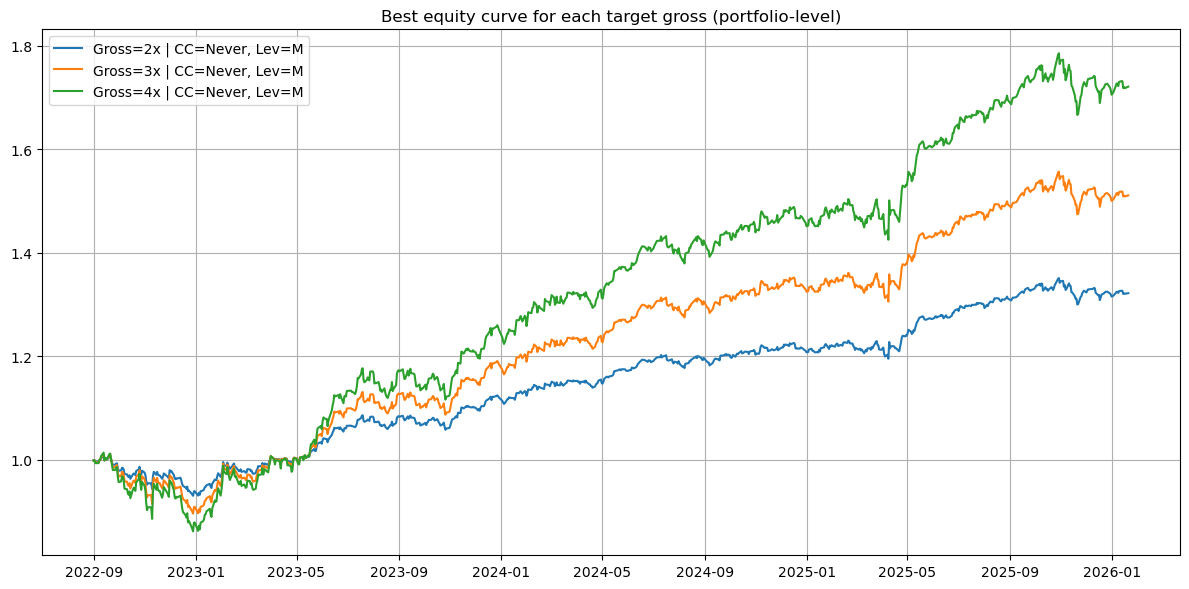

In [35]:
gross_levels = [2, 3, 4]

rets_bt = rets.loc[rets.index >= start_dt].copy()

cc_pairs  = list(ym_df[["Underlying","ETF"]].itertuples(index=False, name=None))
lev_pairs = list(dx_df[["Underlying","ETF"]].itertuples(index=False, name=None))

all_results = []
best_curves = {}   # (gross -> (label, curve))
best_rows   = []   # summary rows

for g in gross_levels:
    results = []
    curves  = {}

    for cc_f, lev_f in combos:
        port_ret, ret_cc, ret_lev, pc_cc, pc_lev = simulate_hybrid_realistic_with_drift(
            rets_bt,
            borrow_daily_map,
            cc_pairs,
            lev_pairs,
            cc_freq=cc_f,
            lev_freq=lev_f,
            sleeve_weight_mode="equal",
            target_gross_sleeve=float(g),   # <-- portfolio gross will be ~g if both sleeves same
            cap_drift=True,
            gross_cap_mult=10.0,
        )

        label = f"Gross={g}x | CC={cc_f}, Lev={lev_f}"
        s = perf_stats(port_ret, label)

        cc_stats  = summarize_pair_count(pc_cc, min_pairs=20, prefix="CC_")
        lev_stats = summarize_pair_count(pc_lev, min_pairs=20, prefix="Lev_")

        row = {"TargetGross": g, "CC_freq": cc_f, "Lev_freq": lev_f, **s, **cc_stats, **lev_stats}
        results.append(row)
        curves[label] = (1 + port_ret).cumprod()

    res_df = pd.DataFrame(results).sort_values("CAGR", ascending=False)
    all_results.append(res_df)

    # print table for this gross
    print(f"\n===== Target Gross (portfolio) ≈ {g}x =====")
    print(res_df[["TargetGross","CC_freq","Lev_freq","CAGR","Vol","MaxDD","TradingDays","Portfolio"]].to_string(index=False))

    # track best combo curve
    best = res_df.iloc[0].to_dict()
    best_rows.append({
        "TargetGross": g,
        "Best_CC": best["CC_freq"],
        "Best_Lev": best["Lev_freq"],
        "Best_CAGR": best["CAGR"],
        "Best_Vol": best["Vol"],
        "Best_MaxDD": best["MaxDD"],
        "TradingDays": best["TradingDays"],
    })

    # find best label
    best_label = f"Gross={g}x | CC={best['CC_freq']}, Lev={best['Lev_freq']}"
    best_curves[g] = (best_label, curves[best_label])

# Summary table: best per gross
best_df = pd.DataFrame(best_rows).sort_values("TargetGross")
print("\n===== Best combo by gross =====")
print(best_df.to_string(index=False))

# Plot: best equity curve per gross
plt.figure(figsize=(12, 6))
for g, (lbl, curve) in best_curves.items():
    plt.plot(curve.index, curve.values, label=lbl)
plt.title("Best equity curve for each target gross (portfolio-level)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
def compute_leg_stats(tr_price: pd.Series, trading_days: int = 252):
    """
    Given a total-return price series (long), compute stats and daily returns.
    Returns:
        stats: dict with cagr, vol_annual, etc.
        ret:   daily simple returns (aligned with tr_price.index[1:])
    """
    tr_price = tr_price.dropna()
    if len(tr_price) < 3:
        return None, pd.Series(dtype=float)

    ret = tr_price.pct_change().dropna()
    T = len(ret)

    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1.0
    vol_annual = ret.std() * np.sqrt(trading_days)

    stats = {
        "cagr": cagr,
        "vol_annual": vol_annual,
        "n_obs": T,
    }
    return stats, ret

In [37]:
results_df = pd.DataFrame(results).sort_values("CAGR", ascending=False)

cols = [
    "CC_freq", "Lev_freq",
    "CAGR", "Vol", "MaxDD", "TradingDays",
    "CC_MinPairs", "CC_MaxPairs", "CC_AvgPairs", "CC_FirstDate_20pairs",
    "Lev_MinPairs", "Lev_MaxPairs", "Lev_AvgPairs", "Lev_FirstDate_20pairs",
]

print(results_df[cols].to_string(index=False))


CC_freq Lev_freq     CAGR      Vol     MaxDD  TradingDays  CC_MinPairs  CC_MaxPairs  CC_AvgPairs CC_FirstDate_20pairs  Lev_MinPairs  Lev_MaxPairs  Lev_AvgPairs Lev_FirstDate_20pairs
  Never        M 0.174920 0.121590 -0.150148          849            6            6     6.000000                  NaT             3            69     23.050648   2024-07-31 04:00:00
  Never        Q 0.171585 0.123318 -0.120537          828            6            6     6.000000                  NaT             5            69     22.134058   2024-09-30 04:00:00
  Never        W 0.167077 0.120167 -0.172039          862            6            6     6.000000                  NaT             3            69     23.374710   2024-07-26 04:00:00
      M        M 0.156131 0.117307 -0.160505          849            8           37    20.526502  2024-06-28 04:00:00             3            69     23.050648   2024-07-31 04:00:00
      Q        M 0.155410 0.120166 -0.160835          849            7           37    19.

In [41]:
# ============================================
# FIXED-SHARE (DISCRETE) REBALANCE SIMULATOR
# - Targets gross exposure at each rebalance date
# - Holds SHARES constant between rebalances
# - Charges borrow on short notional daily
#
# Drop this into a fresh notebook and run top-to-bottom.
# You only need to provide:
#   1) dx_df and ym_df (Underlying/ETF columns)
#   2) a TR price-level series loader (get_total_return_series)
#   3) optional borrow_map
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------
# CONFIG
# ------------------------------
TRADING_DAYS = 252
DEFAULT_BORROW_ANNUAL = 0.05  # 5%

# hedge ratios
CC_SHORT_RATIO   = -1.0   # long 1x underlying : short 1x covered-call ETF
LEV2_SHORT_RATIO = -0.5   # long 1x underlying : short 0.5x 2x ETF

# ------------------------------
# REQUIRED INPUTS YOU MUST PROVIDE
# ------------------------------
# 1) dx_df and ym_df must exist in your notebook environment
#    with at least columns: ["Underlying","ETF"]
#
# dx_df = pd.read_csv("...")  # your 2x mapping universe
# ym_df = pd.read_csv("...")  # your covered call mapping universe
import time
import pandas as pd
import yfinance as yf

_TR_CACHE: dict[str, pd.Series] = {}

def get_total_return_series(
    sym: str,
    start: str = "2018-01-01",
    max_retries: int = 4,
    pause_s: float = 1.0,
) -> pd.Series:
    """
    Returns a price-level TR proxy using Yahoo Adj Close.
    - Retries on timeouts / transient failures.
    - Returns empty Series on permanent failure.
    """
    sym = str(sym).strip().upper().replace(".", "-")

    if sym in _TR_CACHE:
        return _TR_CACHE[sym]

    last_err = None
    for attempt in range(1, max_retries + 1):
        try:
            df = yf.download(
                sym,
                start=start,
                auto_adjust=False,
                progress=False,
                threads=False,   # IMPORTANT: reduces flakiness
                timeout=30,      # IMPORTANT: default is often too low
            )
            if df is None or df.empty:
                _TR_CACHE[sym] = pd.Series(dtype=float)
                return _TR_CACHE[sym]

            col = "Adj Close" if "Adj Close" in df.columns else "Close"
            s = df[col].dropna().astype(float)
            if s.empty:
                _TR_CACHE[sym] = pd.Series(dtype=float)
                return _TR_CACHE[sym]

            s = s[~s.index.duplicated(keep="last")].sort_index()
            s.index = pd.to_datetime(s.index).tz_localize(None)

            _TR_CACHE[sym] = s
            return s

        except Exception as e:
            last_err = e
            time.sleep(pause_s * attempt)

    # exhausted retries
    print(f"[WARN] yfinance failed for {sym} after {max_retries} retries: {last_err}")
    _TR_CACHE[sym] = pd.Series(dtype=float)
    return _TR_CACHE[sym]


# 3) Optional: current borrow map (annualized rates). If missing, DEFAULT_BORROW_ANNUAL used.
# borrow_map = {"MSTY": 0.15, "default": 0.05}


# ============================================================
# HELPERS (your versions, included verbatim / compatible)
# ============================================================
def first_valid_date(rets: pd.DataFrame, sym: str) -> pd.Timestamp | None:
    candidates = [f"{sym}_TR", sym]
    for col in candidates:
        if col in rets.columns:
            s = rets[col]
            fv = s.first_valid_index()
            if fv is not None:
                return pd.Timestamp(fv)
    return None

def build_pair_start_dates(rets: pd.DataFrame, pairs: list[tuple[str, str]]):
    pair_start = {}
    for und, etf in pairs:
        und0 = und.replace(".", "-")
        etf0 = etf.replace(".", "-")

        d1 = first_valid_date(rets, und0)
        d2 = first_valid_date(rets, etf0)

        if d1 is None or d2 is None:
            continue

        pair_start[(und0, etf0)] = max(d1, d2)
    return pair_start

def build_pairs_from_df(df: pd.DataFrame, und_col: str="Underlying", etf_col: str="ETF") -> list[tuple[str,str]]:
    return list(zip(
        df[und_col].astype(str).str.replace(".", "-", regex=False),
        df[etf_col].astype(str).str.replace(".", "-", regex=False),
    ))


# ============================================================
# REBALANCE CALENDAR (robust)
# ============================================================
def get_rebalance_days(index: pd.DatetimeIndex, freq: str) -> set[pd.Timestamp]:
    """
    Returns a set of rebalance timestamps (must match index values exactly).
    Supported:
      - "D" daily
      - "W" weekly (last trading day of each week)
      - "M" monthly (last trading day of each month)
      - "Q" quarterly (last trading day of each quarter)
      - "NEVER" only the first eligible day will lock (handled in sim if you want)
    """
    if len(index) == 0:
        return set()

    freq_u = str(freq).upper()
    idx = pd.DatetimeIndex(index)

    if freq_u in ("D", "DAILY"):
        return set(idx)

    # group-by periods and take last trading day in that period
    if freq_u in ("W", "WEEKLY"):
        periods = idx.to_period("W-FRI")
    elif freq_u in ("M", "MONTHLY"):
        periods = idx.to_period("M")
    elif freq_u in ("Q", "QUARTERLY"):
        periods = idx.to_period("Q")
    elif freq_u == "NEVER":
        return set()  # handled in sim
    else:
        raise ValueError(f"Unsupported freq: {freq}")

    # last index entry for each period
    s = pd.Series(idx, index=idx)
    last_by_period = s.groupby(periods).max().values
    return set(pd.to_datetime(last_by_period))


# ============================================================
# BORROW HANDLING
# ============================================================
def get_borrow_annual(sym: str) -> float:
    if "borrow_map" in globals() and borrow_map is not None:
        if sym in borrow_map:
            return float(borrow_map[sym])
        if "default" in borrow_map:
            return float(borrow_map["default"])
    return float(DEFAULT_BORROW_ANNUAL)

def make_borrow_daily_map(etfs: list[str]) -> dict[str, float]:
    return {etf: get_borrow_annual(etf) / TRADING_DAYS for etf in etfs}


# ============================================================
# PERFORMANCE UTILS
# ============================================================
def perf_stats(ret: pd.Series, label: str) -> dict:
    ret = ret.dropna()
    T = len(ret)
    if T == 0:
        return {"Portfolio": label, "TradingDays": 0, "CAGR": np.nan, "Vol": np.nan, "MaxDD": np.nan}
    curve = (1 + ret).cumprod()
    cumulative = curve.iloc[-1]
    cagr = cumulative ** (TRADING_DAYS / T) - 1
    vol = ret.std(ddof=0) * np.sqrt(TRADING_DAYS)
    dd = (curve / curve.cummax() - 1).min()
    return {"Portfolio": label, "TradingDays": T, "CAGR": cagr, "Vol": vol, "MaxDD": dd}

def summarize_pair_count(pc: pd.Series, min_pairs: int = 0, prefix: str = "") -> dict:
    pc = pc.dropna()
    if pc.empty:
        return {f"{prefix}Pairs_mean": np.nan, f"{prefix}Pairs_min": np.nan, f"{prefix}Pairs_pct_ge_{min_pairs}": np.nan}
    return {
        f"{prefix}Pairs_mean": float(pc.mean()),
        f"{prefix}Pairs_min": float(pc.min()),
        f"{prefix}Pairs_pct_ge_{min_pairs}": float((pc >= min_pairs).mean()),
    }


# ============================================================
# CORE: FIXED-SHARE, DISCRETE REBALANCE TO TARGET GROSS
# ============================================================
def simulate_sleeve_fixed_shares_rebalanced_to_gross(
    tr_prices: pd.DataFrame,          # columns like "MSTR_TR", "MSTY_TR"
    pairs: list[tuple[str, str]],
    short_ratio: float,               # -1.0 CC, -0.5 lev2
    borrow_daily_map: dict[str, float],
    freq: str = "M",
    start_when_first_pair_active: bool = True,
    target_gross_mult: float = 4.0,   # gross = mult * equity at rebalance
    initial_equity: float = 1.0,
    default_borrow_daily: float = DEFAULT_BORROW_ANNUAL / TRADING_DAYS,
    lock_universe_if_never: bool = True,
):
    # tz hygiene
    px = tr_prices.copy()
    if px.index.tz is not None:
        px.index = px.index.tz_convert("UTC").tz_localize(None)

    idx = px.index
    rebal_days = get_rebalance_days(idx, freq)

    # pair start dates (needs both legs to exist)
    pair_start = build_pair_start_dates(px, pairs)

    # state
    equity = float(initial_equity)
    shares_under = pd.Series(dtype=float)  # + shares
    shares_etf   = pd.Series(dtype=float)  # - shares (short)
    port_ret = pd.Series(index=idx, dtype=float)
    pair_count = pd.Series(index=idx, dtype=int)

    first_active_day = None
    locked_pairs = None

    def eligible_pairs_on(t):
        elig = []
        for (und, etf), d0 in pair_start.items():
            if d0 is None or d0 > t:
                continue
            elig.append((und, etf))
        return elig

    def rebalance_to_target_gross(t, active_pairs):
        nonlocal shares_under, shares_etf

        n = len(active_pairs)
        if n == 0:
            shares_under = pd.Series(dtype=float)
            shares_etf   = pd.Series(dtype=float)
            return

        gross_target = target_gross_mult * equity

        # gross per pair split across legs
        # per-pair gross = a + a*|sr| = a*(1+|sr|)
        gross_per_pair = gross_target / n
        a = gross_per_pair / (1.0 + abs(short_ratio))  # dollars long underlying per pair

        su = {}
        se = {}

        for und, etf in active_pairs:
            und_col = f"{und}_TR"
            etf_col = f"{etf}_TR"
            if und_col not in px.columns or etf_col not in px.columns:
                continue

            pu = float(px.at[t, und_col])
            pe = float(px.at[t, etf_col])
            if not np.isfinite(pu) or pu <= 0 or not np.isfinite(pe) or pe <= 0:
                continue

            long_u_dol  = a
            short_e_dol = a * abs(short_ratio)

            su[und] = su.get(und, 0.0) + (long_u_dol / pu)
            se[etf] = se.get(etf, 0.0) - (short_e_dol / pe)  # negative shares == short

        shares_under = pd.Series(su, dtype=float)
        shares_etf   = pd.Series(se, dtype=float)

    prev_t = None
    for t in idx:
        # rebalance logic
        if str(freq).upper() == "NEVER" and lock_universe_if_never:
            if locked_pairs is None:
                elig = eligible_pairs_on(t)
                if len(elig) > 0:
                    locked_pairs = elig
                    rebalance_to_target_gross(t, locked_pairs)
                    if first_active_day is None:
                        first_active_day = t
            pair_count.at[t] = 0 if locked_pairs is None else len(locked_pairs)

        else:
            if t in rebal_days:
                active_pairs = eligible_pairs_on(t)
                pair_count.at[t] = len(active_pairs)
                if first_active_day is None and len(active_pairs) > 0:
                    first_active_day = t
                rebalance_to_target_gross(t, active_pairs)
            else:
                pair_count.at[t] = 0 if prev_t is None else int(pair_count.at[prev_t])

        # no holdings => cash return
        if shares_under.empty and shares_etf.empty:
            port_ret.at[t] = 0.0
            prev_t = t
            continue

        # need prev day to compute pnl
        if prev_t is None:
            port_ret.at[t] = 0.0
            prev_t = t
            continue

        pnl = 0.0

        # underlying pnl
        for und, sh in shares_under.items():
            col = f"{und}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            p1 = float(px.at[t, col])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

        # etf pnl + borrow on prev-day notional
        borrow_cost = 0.0
        for etf, sh in shares_etf.items():
            col = f"{etf}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            p1 = float(px.at[t, col])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)  # sh negative => gains when ETF falls

            b = float(borrow_daily_map.get(etf, default_borrow_daily))
            if np.isfinite(p0):
                borrow_cost += abs(float(sh)) * p0 * b

        pnl -= borrow_cost

        r = pnl / equity if equity != 0 else 0.0
        equity *= (1.0 + r)
        port_ret.at[t] = r

        prev_t = t

    if start_when_first_pair_active and first_active_day is not None:
        port_ret = port_ret.loc[first_active_day:]
        pair_count = pair_count.loc[first_active_day:]

    return port_ret.dropna(), pair_count


# ============================================================
# HYBRID WRAPPER: CC sleeve + LEV sleeve
# ============================================================
def simulate_hybrid_fixed_shares(
    tr_prices: pd.DataFrame,
    borrow_daily_map: dict[str, float],
    cc_pairs: list[tuple[str, str]],
    lev_pairs: list[tuple[str, str]],
    cc_freq: str = "M",
    lev_freq: str = "W",
    target_gross_mult_sleeve: float = 4.0,  # per sleeve gross = mult * sleeve equity
    sleeve_mix: float = 0.5,                # 0.5 means 50/50 equity split
):
    # simulate each sleeve on its own equity, then mix returns
    ret_cc, pc_cc = simulate_sleeve_fixed_shares_rebalanced_to_gross(
        tr_prices, cc_pairs, short_ratio=CC_SHORT_RATIO,
        borrow_daily_map=borrow_daily_map, freq=cc_freq,
        target_gross_mult=target_gross_mult_sleeve
    )

    ret_lev, pc_lev = simulate_sleeve_fixed_shares_rebalanced_to_gross(
        tr_prices, lev_pairs, short_ratio=LEV2_SHORT_RATIO,
        borrow_daily_map=borrow_daily_map, freq=lev_freq,
        target_gross_mult=target_gross_mult_sleeve
    )

    common = ret_cc.index.intersection(ret_lev.index)
    if common.empty:
        raise ValueError("No overlapping dates between sleeves.")

    ret_cc = ret_cc.loc[common]
    ret_lev = ret_lev.loc[common]
    pc_cc = pc_cc.loc[common]
    pc_lev = pc_lev.loc[common]

    w = float(sleeve_mix)
    port_ret = w * ret_cc + (1.0 - w) * ret_lev

    return port_ret.dropna(), ret_cc, ret_lev, pc_cc, pc_lev


# ============================================================
# BUILD PRICES DF FROM YOUR UNIVERSE (dx_df + ym_df)
# ============================================================
def build_tr_prices_for_universe(dx_df: pd.DataFrame, ym_df: pd.DataFrame):
    dx = dx_df.copy()
    ym = ym_df.copy()

    dx["LevType"] = "2x"
    ym["LevType"] = "CC"

    # normalize tickers
    for df in (dx, ym):
        for c in ["Underlying", "ETF"]:
            df[c] = (
                df[c].astype(str)
                .str.strip()
                .str.replace(".", "-", regex=False)
                .str.upper()
            )

    cc_pairs  = build_pairs_from_df(ym)
    lev_pairs = build_pairs_from_df(dx)

    # unique symbols to load
    all_syms = sorted(set([u for u, e in cc_pairs + lev_pairs] + [e for u, e in cc_pairs + lev_pairs]))

    price_dict: dict[str, pd.Series] = {}
    ok_syms: set[str] = set()

    for sym in all_syms:
        s = get_total_return_series(sym)
        if s is None or len(s) == 0:
            print(f"WARNING: no TR data for {sym}; skipping.")
            continue
        s = s.copy()
        if s.index.tz is not None:
            s.index = s.index.tz_convert("UTC").tz_localize(None)

        price_dict[f"{sym}_TR"] = s
        ok_syms.add(sym)

    # if nothing loaded, fail with a clear message (no pandas scalar-index error)
    if len(price_dict) == 0:
        raise RuntimeError(
            "No symbols loaded from yfinance (all failed/timeouts). "
            "Try again, increase timeout/retries, or load prices from your local cache."
        )

    # build prices table (union of all indices)
    prices = pd.concat(price_dict, axis=1).sort_index()

    # filter pairs to only those with BOTH legs loaded
    cc_pairs_ok  = [(u, e) for (u, e) in cc_pairs  if u in ok_syms and e in ok_syms]
    lev_pairs_ok = [(u, e) for (u, e) in lev_pairs if u in ok_syms and e in ok_syms]

    if len(cc_pairs_ok) == 0 and len(lev_pairs_ok) == 0:
        raise RuntimeError(
            "Loaded some symbols, but no complete pairs have both legs available."
        )

    print(f"Loaded symbols: {len(ok_syms)} / {len(all_syms)}")
    print(f"Usable CC pairs: {len(cc_pairs_ok)} / {len(cc_pairs)}")
    print(f"Usable Lev pairs: {len(lev_pairs_ok)} / {len(lev_pairs)}")

    return prices, cc_pairs_ok, lev_pairs_ok


# ============================================================
# RUN A TEST GRID (similar to your prior loop)
# ============================================================
def run_grid_test(
    prices: pd.DataFrame,
    cc_pairs: list[tuple[str,str]],
    lev_pairs: list[tuple[str,str]],
    cc_freqs=("M",),
    lev_freqs=("W",),
    gross_levels=(2,3,4),
    backtest_start="2022-01-01",
):
    # restrict dates
    start_dt = pd.Timestamp(backtest_start)
    prices_bt = prices.loc[prices.index >= start_dt].copy()
    if prices_bt.empty:
        raise ValueError("No price data after backtest_start.")

    # build borrow map only for ETFs (short legs)
    all_etfs = sorted(set([e for _, e in cc_pairs] + [e for _, e in lev_pairs]))
    borrow_daily_map = make_borrow_daily_map(all_etfs)

    all_results = []
    best_curves = {}
    best_rows = []

    combos = [(a,b) for a in cc_freqs for b in lev_freqs]

    for g in gross_levels:
        rows = []
        curves = {}

        for cc_f, lev_f in combos:
            port_ret, ret_cc, ret_lev, pc_cc, pc_lev = simulate_hybrid_fixed_shares(
                prices_bt, borrow_daily_map, cc_pairs, lev_pairs,
                cc_freq=cc_f, lev_freq=lev_f,
                target_gross_mult_sleeve=float(g),
                sleeve_mix=0.5
            )

            label = f"Gross={g}x | CC={cc_f}, Lev={lev_f}"
            s = perf_stats(port_ret, label)
            cc_stats  = summarize_pair_count(pc_cc, min_pairs=20, prefix="CC_")
            lev_stats = summarize_pair_count(pc_lev, min_pairs=20, prefix="Lev_")

            rows.append({"TargetGross": g, "CC_freq": cc_f, "Lev_freq": lev_f, **s, **cc_stats, **lev_stats})
            curves[label] = (1 + port_ret).cumprod()

        res_df = pd.DataFrame(rows).sort_values("CAGR", ascending=False)
        all_results.append(res_df)

        print(f"\n===== Target Gross (per sleeve) = {g}x equity =====")
        print(res_df[["TargetGross","CC_freq","Lev_freq","CAGR","Vol","MaxDD","TradingDays","Portfolio"]].to_string(index=False))

        best = res_df.iloc[0].to_dict()
        best_rows.append({
            "TargetGross": g,
            "Best_CC": best["CC_freq"],
            "Best_Lev": best["Lev_freq"],
            "Best_CAGR": best["CAGR"],
            "Best_Vol": best["Vol"],
            "Best_MaxDD": best["MaxDD"],
            "TradingDays": best["TradingDays"],
        })

        best_label = f"Gross={g}x | CC={best['CC_freq']}, Lev={best['Lev_freq']}"
        best_curves[g] = (best_label, curves[best_label])

    best_df = pd.DataFrame(best_rows).sort_values("TargetGross")
    print("\n===== Best combo by gross =====")
    print(best_df.to_string(index=False))

    plt.figure(figsize=(12,6))
    for g, (lbl, curve) in best_curves.items():
        plt.plot(curve.index, curve.values, label=lbl)
    plt.title("Best equity curve for each target gross (fixed-shares, discrete rebalance)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_results, best_df


# ============================================================
# MAIN (YOU RUN THIS)
# ============================================================
# 1) Ensure dx_df and ym_df exist, then:
prices, cc_pairs, lev_pairs = build_tr_prices_for_universe(dx_df, ym_df)

# 2) Run a quick grid:
all_results, best_df = run_grid_test(
    prices,
    cc_pairs,
    lev_pairs,
    cc_freqs=("M","Q"),
    lev_freqs=("W","M"),
    gross_levels=(2,3,4),
    backtest_start="2022-01-01",
)

# borrow_daily_map = make_borrow_daily_map(sorted(set([e for _,e in cc_pairs]+[e for _,e in lev_pairs])))
# port_ret, ret_cc, ret_lev, pc_cc, pc_lev = simulate_hybrid_fixed_shares(
#     prices.loc[prices.index >= "2022-01-01"],
#     borrow_daily_map,
#     cc_pairs, lev_pairs,
#     cc_freq="M", lev_freq="W",
#     target_gross_mult_sleeve=4.0,
#     sleeve_mix=0.5
# )
# print(perf_stats(port_ret, "Hybrid"))
# (1+port_ret).cumprod().plot(title="Hybrid equity curve (fixed-shares)")
# plt.grid(True); plt.show()


Loaded symbols: 171 / 171
Usable CC pairs: 39 / 39
Usable Lev pairs: 71 / 71


TypeError: only integer scalar arrays can be converted to a scalar index